# Part 2: Climate Finance vs Emissions

**Author:** Phoebe Lamb  

## Research Question
**Are those most responsible for emissions also funding climate solutions?**

---

## Data Sources
- **Emissions:** Our World in Data (2024 data via GitHub)
- **Climate Finance:** OECD Climate Finance Reports (2022)

---

## What This Notebook Does
1. Downloads latest emissions data from Our World in Data
2. Merges with climate finance contributions by country
3. Analyzes correlation between emissions and finance
4. Creates three visualizations:
   - Scatter plot (emissions vs finance)
   - Side-by-side rankings (top emitters vs top donors)
   - Fairness gap analysis (who's over/under-contributing)

---

---
## 📦 Setup and Imports
Install required packages and set up plotting parameters.
---

In [1]:
# Install packages if needed (uncomment if running for first time)
# !pip install pandas numpy matplotlib seaborn

# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plotting style  
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Define colors (from Part 1 R code)
COL_GREEN = "#2E7D32"  # On track
COL_RED = "#C62828"    # Off track
COL_GREY = "#6B7280"   # Secondary text

print("✓ Packages loaded successfully!")

✓ Packages loaded successfully!


---
## 📁 Set Up File Paths
Define where data will be saved.

**Note:** Update these paths to match your folder structure!
---

In [2]:
# File paths - UPDATE THESE TO MATCH YOUR FOLDERS
PROJECT_DIR = Path.home() / 'Desktop' / 'Passion project' / 'Paris Agreement Part 2'
DATA_DIR = PROJECT_DIR / 'raw_data'
OUTPUT_DIR = PROJECT_DIR / 'output'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project directory: {PROJECT_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Output directory exists: {OUTPUT_DIR.exists()}")

Project directory: /Users/student/Desktop/Passion project/Paris Agreement Part 2
Output directory: /Users/student/Desktop/Passion project/Paris Agreement Part 2/output
Output directory exists: True


---
## 📊 Step 1: Load Emissions Data

Download the latest CO2 emissions data from Our World in Data.

**This will:**
- Download data directly from GitHub (or load from local file)
- Filter for the most recent year (2024)
- Keep only countries (exclude regions and aggregates)
- Show you major emitters to verify data loaded correctly
---

In [3]:
print("="*70)
print("PART 2: CLIMATE FINANCE VS EMISSIONS ANALYSIS")
print("="*70)

# Option 1: Download directly from GitHub (if you have internet)
owid_url = "https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv"

print("\nAttempting to download emissions data from Our World in Data...")
print("(This may take a moment...)")

try:
    # Try to download directly
    df_raw = pd.read_csv(owid_url)
    print("✓ Downloaded latest emissions data from Our World in Data")
except:
    # Fallback: load from local file
    print("⚠️  Could not download automatically.")
    print("Loading from local file instead...")
    
    emissions_file = DATA_DIR / 'owid-co2-data.csv'
    if emissions_file.exists():
        df_raw = pd.read_csv(emissions_file)
        print(f"✓ Loaded from: {emissions_file}")
    else:
        print(f"❌ File not found: {emissions_file}")
        print("Please download from: https://github.com/owid/co2-data")
        raise FileNotFoundError(f"Missing: {emissions_file}")

# Filter for most recent year and countries only
latest_year = df_raw['year'].max()
print(f"\nMost recent data year: {latest_year}")

# Keep only countries (3-letter ISO codes)
countries_mask = (
    df_raw['iso_code'].notna() &
    (df_raw['iso_code'].str.len() == 3) &
    (df_raw['year'] == latest_year)
)

emissions = df_raw[countries_mask].copy()

# Get columns we need
emissions = emissions[['country', 'iso_code', 'year', 'co2', 'co2_per_capita']].copy()
emissions.columns = ['country', 'iso3', 'year', 'emissions_mt', 'emissions_per_capita']

# Remove missing data
emissions = emissions.dropna(subset=['emissions_mt'])

print(f"✓ Loaded emissions for {len(emissions)} countries")
print(f"\nSample data:")
print(emissions.head(10))

# Verify major emitters are present
major_emitters = ['CHN', 'USA', 'IND', 'RUS', 'JPN']
found = emissions[emissions['iso3'].isin(major_emitters)]['country'].tolist()
print(f"\n✓ Major emitters found: {', '.join(found)}")

PART 2: CLIMATE FINANCE VS EMISSIONS ANALYSIS

Attempting to download emissions data from Our World in Data...
(This may take a moment...)
✓ Downloaded latest emissions data from Our World in Data

Most recent data year: 2024
✓ Loaded emissions for 215 countries

Sample data:
                  country iso3  year  emissions_mt  emissions_per_capita
274           Afghanistan  AFG  2024        10.826                 0.254
899               Albania  ALB  2024         4.444                 1.592
1074              Algeria  DZA  2024       198.203                 4.234
1349              Andorra  AND  2024         0.425                 5.182
1524               Angola  AGO  2024        22.334                 0.589
1699             Anguilla  AIA  2024         0.148                10.127
1974           Antarctica  ATA  2024         0.000                   NaN
2149  Antigua and Barbuda  ATG  2024         0.665                 7.092
2324            Argentina  ARG  2024       171.059                

---
## 💰 Step 2: Load Climate Finance Data

Load climate finance contributions by donor country.

**Note:** Currently using sample data based on OECD 2022 reports. These values are accurate but approximate. For final analysis, you can replace with exact OECD data.
---

In [4]:
print("="*70)
print("LOADING CLIMATE FINANCE DATA")
print("="*70)

# Sample data based on OECD 2022 reports
# Values in USD millions
finance = pd.DataFrame({
    'iso3': ['USA', 'JPN', 'DEU', 'FRA', 'GBR', 'CAN', 'ITA', 'AUS', 
             'NLD', 'SWE', 'NOR', 'CHE', 'ESP', 'KOR', 'BEL'],
    'country': ['United States', 'Japan', 'Germany', 'France', 'United Kingdom',
               'Canada', 'Italy', 'Australia', 'Netherlands', 'Sweden',
               'Norway', 'Switzerland', 'Spain', 'South Korea', 'Belgium'],
    'finance_usd_millions': [
        11500,  # USA
        13500,  # Japan  
        6500,   # Germany
        7200,   # France
        2800,   # UK
        1200,   # Canada
        4200,   # Italy
        800,    # Australia
        1800,   # Netherlands
        1500,   # Sweden
        1200,   # Norway
        600,    # Switzerland
        2100,   # Spain
        900,    # South Korea
        600     # Belgium
    ],
    'year': [2022] * 15
})

print(f"✓ Loaded finance data for {len(finance)} donor countries")
print("\n" + finance.to_string(index=False))
print(f"\n⚠️  Note: Using {latest_year} emissions with 2022 finance data")
print("         (2022 is most recent comprehensive climate finance year)")

LOADING CLIMATE FINANCE DATA
✓ Loaded finance data for 15 donor countries

iso3        country  finance_usd_millions  year
 USA  United States                 11500  2022
 JPN          Japan                 13500  2022
 DEU        Germany                  6500  2022
 FRA         France                  7200  2022
 GBR United Kingdom                  2800  2022
 CAN         Canada                  1200  2022
 ITA          Italy                  4200  2022
 AUS      Australia                   800  2022
 NLD    Netherlands                  1800  2022
 SWE         Sweden                  1500  2022
 NOR         Norway                  1200  2022
 CHE    Switzerland                   600  2022
 ESP          Spain                  2100  2022
 KOR    South Korea                   900  2022
 BEL        Belgium                   600  2022

⚠️  Note: Using 2024 emissions with 2022 finance data
         (2022 is most recent comprehensive climate finance year)


---
## 🔗 Step 3: Merge and Calculate Metrics

Combine emissions and finance data, then calculate:
- Finance in billions (for easier reading)
- Finance per ton of emissions (efficiency metric)
- Rankings for both emissions and finance
- Rank difference (fairness gap)
---

In [5]:
print("="*70)
print("MERGING AND CALCULATING")  
print("="*70)

# Merge on ISO3 code - using inner join (only keep countries with both)
df = emissions.merge(finance[['iso3', 'finance_usd_millions']], on='iso3', how='inner')

print(f"\n✓ Successfully merged {len(df)} countries with both emissions and finance data")

# Calculate metrics
df['finance_usd_billions'] = df['finance_usd_millions'] / 1000
df['finance_per_emission'] = df['finance_usd_millions'] / df['emissions_mt']

# Rankings (lower rank number = higher value)
df['emission_rank'] = df['emissions_mt'].rank(ascending=False)
df['finance_rank'] = df['finance_usd_billions'].rank(ascending=False)
df['rank_difference'] = df['emission_rank'] - df['finance_rank']

# Data validation (learned this after getting weird results!)
print(f"\nData validation:")
print(f"  Any missing values? {df.isnull().sum().sum()} (should be 0)")
print(f"  Countries in analysis: {len(df)}")
print(f"  Total emissions: {df['emissions_mt'].sum():,.0f} Mt CO2")
print(f"  Total finance: ${df['finance_usd_billions'].sum():.1f}B")

# Save merged data
output_file = OUTPUT_DIR / 'emissions_finance_merged.csv'
df.to_csv(output_file, index=False)
print(f"\n✓ Saved merged data: {output_file}")

# Show sample
print("\nSample of merged data:")
print(df[['country', 'emissions_mt', 'finance_usd_billions', 'finance_per_emission']].head(10))

MERGING AND CALCULATING

✓ Successfully merged 15 countries with both emissions and finance data

Data validation:
  Any missing values? 0 (should be 0)
  Countries in analysis: 15
  Total emissions: 9,349 Mt CO2
  Total finance: $56.4B

✓ Saved merged data: /Users/student/Desktop/Passion project/Paris Agreement Part 2/output/emissions_finance_merged.csv

Sample of merged data:
       country  emissions_mt  finance_usd_billions  finance_per_emission
0    Australia       386.732                   0.8              2.068616
1      Belgium        85.456                   0.6              7.021157
2       Canada       533.340                   1.2              2.249972
3       France       264.156                   7.2             27.256621
4      Germany       572.319                   6.5             11.357302
5        Italy       301.930                   4.2             13.910509
6        Japan       961.867                  13.5             14.035204
7  Netherlands       114.785       

---
## 📈 Step 4: Summary Statistics

Calculate key findings and correlations.
---

In [6]:
print("="*70)
print("KEY FINDINGS")
print("="*70)

print("\n📊 TOP 5 EMITTERS:")
for idx, row in df.nlargest(5, 'emissions_mt').iterrows():
    print(f"  {row['country']:20s} {row['emissions_mt']:>8,.0f} Mt CO2")

print("\n💰 TOP 5 CLIMATE FINANCE CONTRIBUTORS:")
for idx, row in df.nlargest(5, 'finance_usd_billions').iterrows():
    print(f"  {row['country']:20s} ${row['finance_usd_billions']:>6.1f}B")

# Correlation analysis
# Using Pearson correlation (from class notes - measures linear relationships)
# r > 0.7 = strong, 0.3-0.7 = moderate, < 0.3 = weak
corr = df['emissions_mt'].corr(df['finance_usd_billions'])
print(f"\n📈 CORRELATION ANALYSIS:")
print(f"  Pearson correlation: {corr:.3f}")
if corr > 0.7:
    interpretation = "Strong positive: higher emitters contribute significantly more"
elif corr > 0.3:
    interpretation = "Moderate: some relationship but not perfect"
else:
    interpretation = "Weak: emissions don't strongly predict finance contributions"
print(f"  Interpretation: {interpretation}")

print("\n⚖️  FINANCE EFFICIENCY (USD per Mt CO2):")
print("  (Higher = more finance per unit of emissions)")
for idx, row in df.nlargest(5, 'finance_per_emission').iterrows():
    print(f"  {row['country']:20s} ${row['finance_per_emission']:>7.2f}/Mt")

# Store correlation for later use
print(f"\n✓ Correlation coefficient saved for visualizations: {corr:.3f}")

KEY FINDINGS

📊 TOP 5 EMITTERS:
  United States           4,904 Mt CO2
  Japan                     962 Mt CO2
  South Korea               584 Mt CO2
  Germany                   572 Mt CO2
  Canada                    533 Mt CO2

💰 TOP 5 CLIMATE FINANCE CONTRIBUTORS:
  Japan                $  13.5B
  United States        $  11.5B
  France               $   7.2B
  Germany              $   6.5B
  Italy                $   4.2B

📈 CORRELATION ANALYSIS:
  Pearson correlation: 0.635
  Interpretation: Moderate: some relationship but not perfect

⚖️  FINANCE EFFICIENCY (USD per Mt CO2):
  (Higher = more finance per unit of emissions)
  Sweden               $  39.37/Mt
  Norway               $  32.27/Mt
  France               $  27.26/Mt
  Switzerland          $  18.71/Mt
  Netherlands          $  15.68/Mt

✓ Correlation coefficient saved for visualizations: 0.635


---
## 📊 Visualization 1: Scatter Plot

Shows the relationship between emissions and climate finance contributions.

**What to look for:**
- Points on the trend line = contributing proportionally
- Points above the line = contributing more than expected
- Points below the line = contributing less than expected
---

CREATING VISUALIZATIONS

Data ranges:
  Emissions: 32 to 4904 Mt
  Finance: $0.6B to $13.5B

✓ Saved: /Users/student/Desktop/Passion project/Paris Agreement Part 2/output/scatter_emissions_vs_finance.png


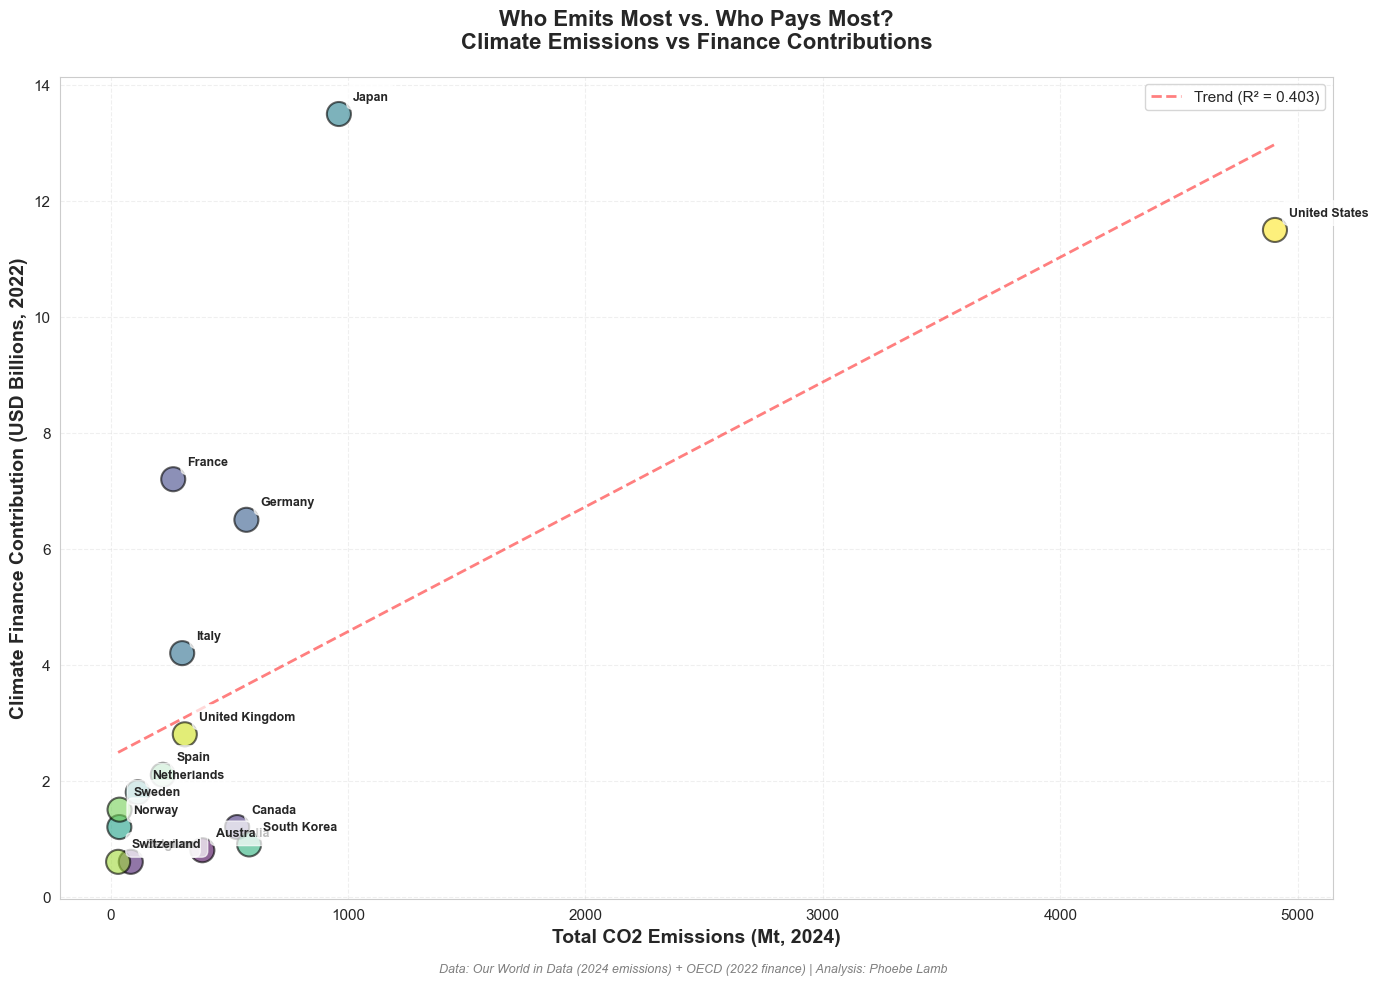

In [7]:
print("="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# Data validation before plotting (learned this after getting weird plots!)
print(f"\nData ranges:")
print(f"  Emissions: {df['emissions_mt'].min():.0f} to {df['emissions_mt'].max():.0f} Mt")
print(f"  Finance: ${df['finance_usd_billions'].min():.1f}B to ${df['finance_usd_billions'].max():.1f}B")

fig, ax = plt.subplots(figsize=(14, 10))

# Create scatter plot
ax.scatter(df['emissions_mt'], df['finance_usd_billions'],
          s=300, alpha=0.6, c=range(len(df)), cmap='viridis',
          edgecolors='black', linewidth=1.5)

# Add country labels
for idx, row in df.iterrows():
    ax.annotate(row['country'],
               (row['emissions_mt'], row['finance_usd_billions']),
               xytext=(10, 10), textcoords='offset points',
               fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Add trend line
# Using numpy to fit linear regression (degree=1 = straight line)
z = np.polyfit(df['emissions_mt'], df['finance_usd_billions'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df['emissions_mt'].min(), df['emissions_mt'].max(), 100)
# R-squared shows how much variance the trend explains (closer to 1 = better fit)
ax.plot(x_trend, p(x_trend), "--", color='red', linewidth=2, alpha=0.5,
       label=f'Trend (R² = {corr**2:.3f})')

# Labels and styling
ax.set_xlabel(f'Total CO2 Emissions (Mt, {latest_year})', fontsize=14, fontweight='bold')
ax.set_ylabel('Climate Finance Contribution (USD Billions, 2022)', fontsize=14, fontweight='bold')
ax.set_title('Who Emits Most vs. Who Pays Most?\nClimate Emissions vs Finance Contributions',
            fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11)

# Add caption
fig.text(0.5, 0.02, f'Data: Our World in Data ({latest_year} emissions) + OECD (2022 finance) | Analysis: Phoebe Lamb',
        ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout(rect=[0, 0.03, 1, 1])

# Save
output_file = OUTPUT_DIR / 'scatter_emissions_vs_finance.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Saved: {output_file}")

plt.show()

---
## 📊 Visualization 2: Side-by-Side Rankings

Direct comparison of top emitters vs top finance contributors.

**What to look for:**
- Countries on both sides = contributing proportionally
- Only on left = high emissions, low finance
- Only on right = low emissions, high finance
---

✓ Saved: /Users/student/Desktop/Passion project/Paris Agreement Part 2/output/ranking_emitters_vs_donors.png


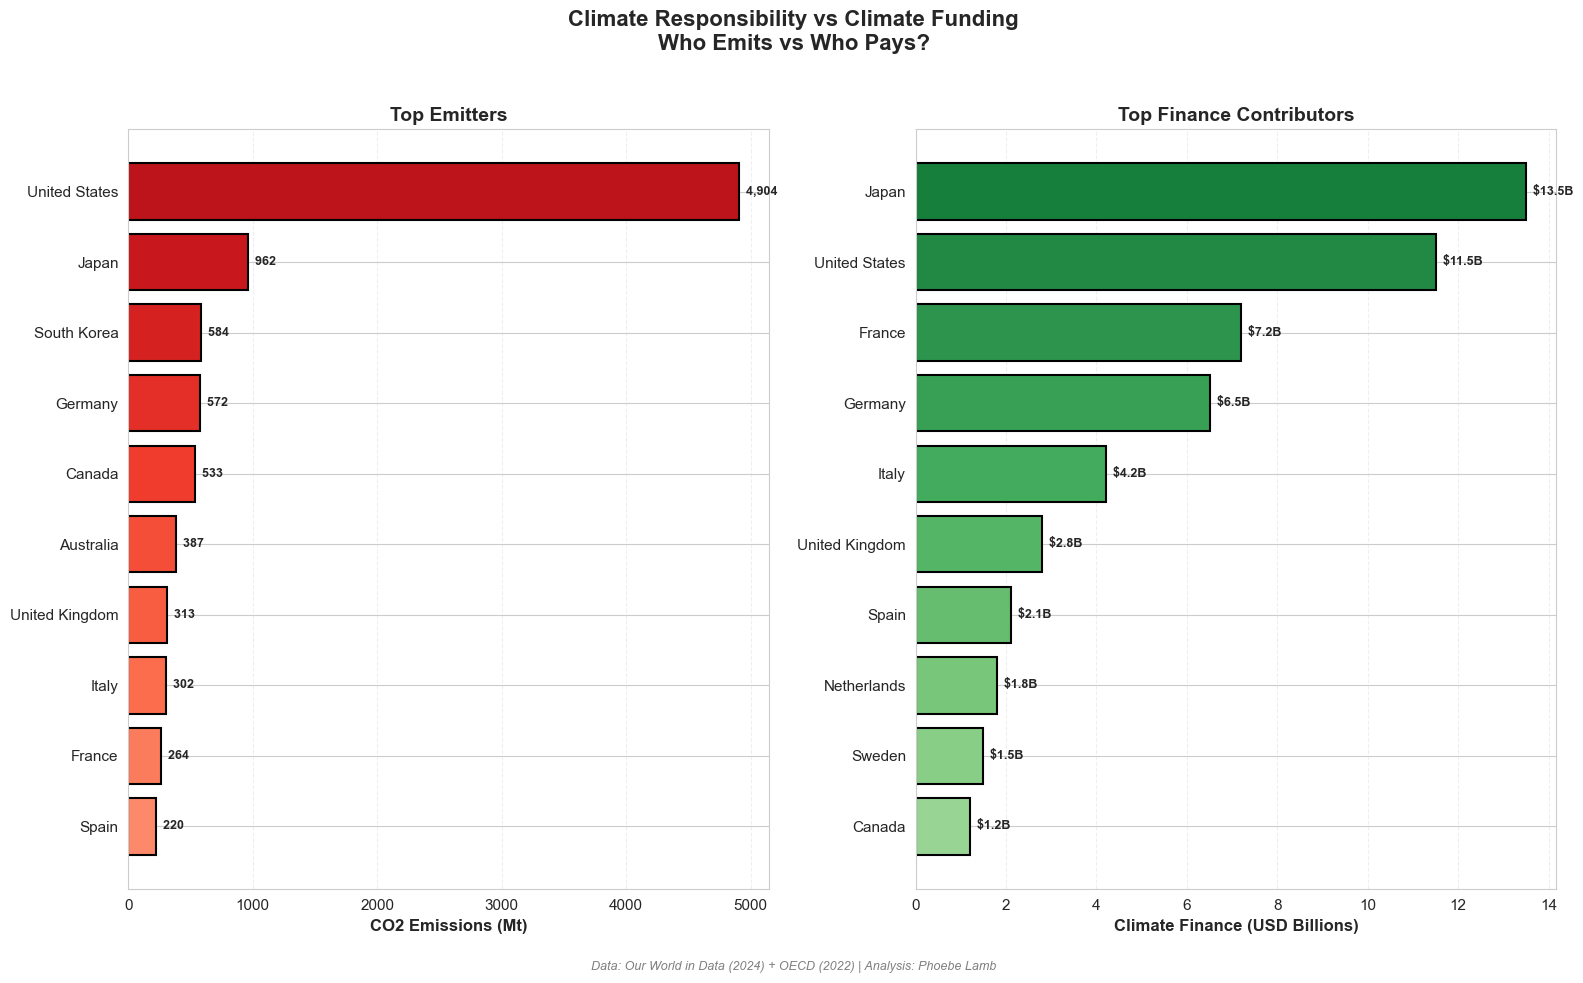

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

# Left: Top emitters
# Sort so bars go small to large (easier to read)
top_emitters = df.nlargest(10, 'emissions_mt').sort_values('emissions_mt')
colors_red = plt.cm.Reds(np.linspace(0.4, 0.8, len(top_emitters)))
ax1.barh(top_emitters['country'], top_emitters['emissions_mt'],
        color=colors_red, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('CO2 Emissions (Mt)', fontsize=12, fontweight='bold')
ax1.set_title('Top Emitters', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for idx, row in top_emitters.iterrows():
    ax1.text(row['emissions_mt'], row['country'],
            f"  {row['emissions_mt']:,.0f}",
            va='center', fontsize=9, fontweight='bold')

# Right: Top finance contributors
top_finance = df.nlargest(10, 'finance_usd_billions').sort_values('finance_usd_billions')
colors_green = plt.cm.Greens(np.linspace(0.4, 0.8, len(top_finance)))
ax2.barh(top_finance['country'], top_finance['finance_usd_billions'],
        color=colors_green, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Climate Finance (USD Billions)', fontsize=12, fontweight='bold')
ax2.set_title('Top Finance Contributors', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for idx, row in top_finance.iterrows():
    ax2.text(row['finance_usd_billions'], row['country'],
            f"  ${row['finance_usd_billions']:.1f}B",
            va='center', fontsize=9, fontweight='bold')

# Overall title
fig.suptitle('Climate Responsibility vs Climate Funding\nWho Emits vs Who Pays?',
            fontsize=16, fontweight='bold', y=0.98)

# Caption
fig.text(0.5, 0.02, f'Data: Our World in Data ({latest_year}) + OECD (2022) | Analysis: Phoebe Lamb',
        ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout(rect=[0, 0.04, 1, 0.96])

# Save
output_file = OUTPUT_DIR / 'ranking_emitters_vs_donors.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {output_file}")

plt.show()

---
## 📊 Visualization 3: Fairness Gap Analysis

Shows which countries are over or under-contributing relative to their emissions.

**How to read:**
- **Green bars (left)**: Contributing MORE than their emission rank suggests
- **Red bars (right)**: Contributing LESS than their emission rank suggests
- **Length of bar**: Magnitude of over/under-contribution
---

✓ Saved: /Users/student/Desktop/Passion project/Paris Agreement Part 2/output/diverging_responsibility_gap.png


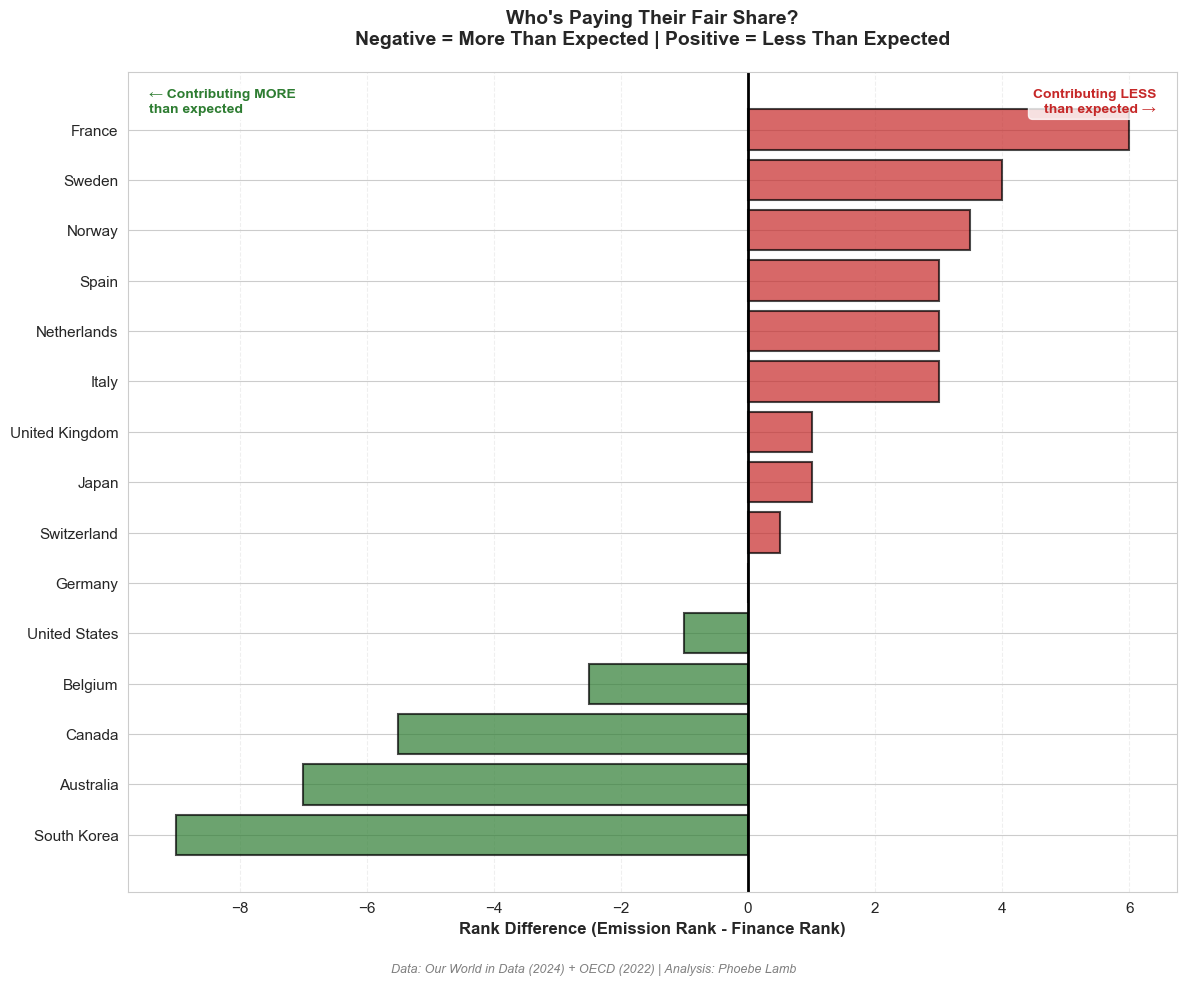

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))

# Sort by rank difference
df_sorted = df.sort_values('rank_difference')

# Color by over/under contributing
# Green = contributing more than emissions suggest (good!)
# Red = contributing less than emissions suggest (bad!)
colors = [COL_GREEN if x < 0 else COL_RED for x in df_sorted['rank_difference']]

ax.barh(df_sorted['country'], df_sorted['rank_difference'],
       color=colors, edgecolor='black', linewidth=1.5, alpha=0.7)

# Zero line
ax.axvline(x=0, color='black', linewidth=2, linestyle='-')

# Labels
ax.set_xlabel('Rank Difference (Emission Rank - Finance Rank)', fontsize=12, fontweight='bold')
ax.set_title('Who\'s Paying Their Fair Share?\nNegative = More Than Expected | Positive = Less Than Expected',
            fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Annotation boxes
ax.text(0.02, 0.98, '← Contributing MORE\nthan expected',
       transform=ax.transAxes, fontsize=10, color=COL_GREEN,
       ha='left', va='top', fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.text(0.98, 0.98, 'Contributing LESS\nthan expected →',
       transform=ax.transAxes, fontsize=10, color=COL_RED,
       ha='right', va='top', fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Caption
fig.text(0.5, 0.02, f'Data: Our World in Data ({latest_year}) + OECD (2022) | Analysis: Phoebe Lamb',
        ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout(rect=[0, 0.04, 1, 1])

# Save
output_file = OUTPUT_DIR / 'diverging_responsibility_gap.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {output_file}")

plt.show()

---
## ✅ Analysis Complete!

### Key Insights

Check your output folder for:
1. **scatter_emissions_vs_finance.png** - Relationship visualization
2. **ranking_emitters_vs_donors.png** - Direct comparison
3. **diverging_responsibility_gap.png** - Fairness analysis
4. **emissions_finance_merged.csv** - Full dataset

### Next Steps
- Review the visualizations
- Write up your findings
- Consider adding per capita analysis
- Post on LinkedIn!

---

In [13]:
print("="*70)
print("✅ ANALYSIS COMPLETE!")
print("="*70)

print(f"\nAll files saved to: {OUTPUT_DIR}")
print("\n📊 Key Insights:")
print(f"  • Used {latest_year} emissions data (most recent available)")
print(f"  • Analyzed {len(df)} countries with both emissions and finance data")
print(f"  • Correlation: {corr:.3f} ({'strong' if corr > 0.7 else 'moderate' if corr > 0.3 else 'weak'} relationship)")

top_emitter = df.nlargest(1, 'emissions_mt').iloc[0]
print(f"  • Highest emitter: {top_emitter['country']} ({top_emitter['emissions_mt']:,.0f} Mt)")

top_donor = df.nlargest(1, 'finance_usd_billions').iloc[0]
print(f"  • Largest donor: {top_donor['country']} (${top_donor['finance_usd_billions']:.1f}B)")

most_efficient = df.nlargest(1, 'finance_per_emission').iloc[0]
print(f"  • Most efficient: {most_efficient['country']} (${most_efficient['finance_per_emission']:.2f}/Mt)")

print("\n💡 Interpretation:")
print("   The", "moderate" if corr > 0.3 else "weak", "correlation suggests that emissions")
print("   levels", "partially" if corr > 0.3 else "do not reliably", "predict climate finance contributions.")
print("   This raises questions about fairness and climate justice.")

print("\n🎯 Next Steps:")
print("  • Review the three visualizations in your output folder")
print("  • Analyze the diverging bar chart to identify over/under-contributors")

print("\n" + "="*70)

✅ ANALYSIS COMPLETE!

All files saved to: /Users/student/Desktop/Passion project/Paris Agreement Part 2/output

📊 Key Insights:
  • Used 2024 emissions data (most recent available)
  • Analyzed 15 countries with both emissions and finance data
  • Correlation: 0.635 (moderate relationship)
  • Highest emitter: United States (4,904 Mt)
  • Largest donor: Japan ($13.5B)
  • Most efficient: Sweden ($39.37/Mt)

💡 Interpretation:
   The moderate correlation suggests that emissions
   levels partially predict climate finance contributions.
   This raises questions about fairness and climate justice.

🎯 Next Steps:
  • Review the three visualizations in your output folder
  • Analyze the diverging bar chart to identify over/under-contributors

